In [1]:
# All imports
import pdb
import os
from pickletools import optimize
from shutil import SpecialFileError
import time
import random
import argparse
import datetime
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist

from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.utils import accuracy, AverageMeter

from config import get_config
from models import build_model
from data import build_loader
from lr_scheduler import build_scheduler
from optimizer import build_optimizer
from logger import create_logger
from utils import load_checkpoint, load_pretrained, save_checkpoint, get_grad_norm, auto_resume_helper, reduce_tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# Init args
def parse_option(config_path, output_path, tag):
    parser = argparse.ArgumentParser('Swin Transformer training and evaluation script', add_help=False)
    parser.add_argument('--cfg', type=str, metavar="FILE", help='path to config file', 
                        default=config_path)
    parser.add_argument(
        "--opts",
        help="Modify config options by adding 'KEY VALUE' pairs. ",
        default=None,
        nargs='+',
    )

    # easy config modification
    parser.add_argument('--batch-size', type=int, help="batch size for single GPU")
    parser.add_argument('--data-path', type=str, help='path to dataset', default=1)
    parser.add_argument('--zip', action='store_true', help='use zipped dataset instead of folder dataset')
    parser.add_argument('--cache-mode', type=str, default='part', choices=['no', 'full', 'part'],
                        help='no: no cache, '
                             'full: cache all data, '
                             'part: sharding the dataset into nonoverlapping pieces and only cache one piece')
    parser.add_argument('--pretrained',
                        help='pretrained weight from checkpoint, could be imagenet22k pretrained weight')
    parser.add_argument('--resume', help='resume from checkpoint')
    parser.add_argument('--accumulation-steps', type=int, help="gradient accumulation steps")
    parser.add_argument('--use-checkpoint', action='store_true',
                        help="whether to use gradient checkpointing to save memory")
    parser.add_argument('--amp-opt-level', type=str, default='O0', choices=['O0', 'O1', 'O2'],
                        help='mixed precision opt level, if O0, no amp is used')
    parser.add_argument('--output', default=output_path, type=str, metavar='PATH',
                        help='root of output folder, the full path is <output>/<model_name>/<tag> (default: output)')
    parser.add_argument('--tag', help='tag of experiment', default=tag)
    parser.add_argument('--eval', action='store_true', help='Perform evaluation only')
    parser.add_argument('--throughput', action='store_true', help='Test throughput only')

    # distributed training
    parser.add_argument(
        "--local_rank", type=int, help='local rank for DistributedDataParallel', default=0
    )

    args, unparsed = parser.parse_known_args()

    config = get_config(args)

    return args, config

def build_val_loader(config):
    from data.build import build_dataset
    from timm.data import Mixup
    config.defrost()
    dataset_train, config.MODEL.NUM_CLASSES = build_dataset(is_train=True, config=config)
    config.freeze()
    dataset_val, _ = build_dataset(is_train=False, config=config)

    

    sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=config.DATA.BATCH_SIZE,
        shuffle=False,
        num_workers=config.DATA.NUM_WORKERS,
        pin_memory=config.DATA.PIN_MEMORY,
        drop_last=False
    )

    # setup mixup / cutmix
    mixup_fn = None
    mixup_active = config.AUG.MIXUP > 0 or config.AUG.CUTMIX > 0. or config.AUG.CUTMIX_MINMAX is not None
    if mixup_active:
        mixup_fn = Mixup(
            mixup_alpha=config.AUG.MIXUP, cutmix_alpha=config.AUG.CUTMIX, cutmix_minmax=config.AUG.CUTMIX_MINMAX,
            prob=config.AUG.MIXUP_PROB, switch_prob=config.AUG.MIXUP_SWITCH_PROB, mode=config.AUG.MIXUP_MODE,
            label_smoothing=config.MODEL.LABEL_SMOOTHING, num_classes=config.MODEL.NUM_CLASSES)

    return dataset_val, data_loader_val, mixup_fn

@torch.no_grad()
def validate(config, data_loader, model, accumulation_steps=1):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()

    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    end = time.time()
    for idx, (images, target) in enumerate(data_loader):
        formatted_images = images.cuda(non_blocking=True).unsqueeze(0)
        formatted_target = target.cuda(non_blocking=True).unsqueeze(0)
        
        A, B, C, H, W = formatted_images.shape
        A, B = formatted_target.shape
        if B // accumulation_steps == 0:
            zero_idx = 1
            ones_idx = B
        else:
            zero_idx = accumulation_steps
            ones_idx = B // accumulation_steps
        formatted_images = formatted_images.reshape(zero_idx, ones_idx, C, H, W)
        formatted_target = formatted_target.reshape(zero_idx, ones_idx)
        
        for accumulation_step in range(accumulation_steps):
            images = formatted_images[accumulation_step]
            target = formatted_target[accumulation_step]
        
            # compute output
            output = model(images, use_amp=False)

            # measure accuracy and record loss
            loss = criterion(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

    #         acc1 = acc1
    #         acc5 = reduce_tensor(acc5)
    #         loss = reduce_tensor(loss)

            loss_meter.update(loss.item(), target.size(0))
            acc1_meter.update(acc1.item(), target.size(0))
            acc5_meter.update(acc5.item(), target.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if idx % config.PRINT_FREQ == 0:
                memory_used = torch.cuda.max_memory_allocated() / (1024.0 * 1024.0)
                print(
                    f'Test: [{idx}/{len(data_loader)}]\t'
                    f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'Loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t'
                    f'Acc@1 {acc1_meter.val:.3f} ({acc1_meter.avg:.3f})\t'
                    f'Acc@5 {acc5_meter.val:.3f} ({acc5_meter.avg:.3f})\t'
                    f'Mem {memory_used:.0f}MB')
            images = images.cpu()
            target = target.cpu()
    print(f' * Acc@1 {acc1_meter.avg:.3f} Acc@5 {acc5_meter.avg:.3f}')
    return acc1_meter.avg, acc5_meter.avg, loss_meter.avg

In [3]:
id2label = {}
with open('/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python/id2label.txt', 'r') as handle:
    for idx, line in enumerate(handle):
        if idx % 2 == 0:
            element, label = line.strip().split(': ')
            id2label[int(element)] = label

# Loading Models
All you need to do to load the models is run everything sequentially up to "Visualize Filters." Each model has a separate dataloader - for some reason you cannot use one model's dataloader for another... - and we can check that they are properly loaded through the "validate" function. Hopefully you'll find the baseline gets ~77.41% and ours gets 79.01%. 

### Swin Transformer Baseline

In [4]:
bl_config_path = 'configs/swin_tiny_patch4_window7_224_cifar100.yaml'
bl_output_path = '/srv/share4/gstoica3/checkpoints/swin_transformer_cifar'
bl_tag = 'baseline_fp32'
_, bl_config = parse_option(bl_config_path, bl_output_path, bl_tag)

=> merge config from configs/swin_tiny_patch4_window7_224_cifar100.yaml


In [5]:
bl_config

CfgNode({'BASE': [''], 'DATA': CfgNode({'BATCH_SIZE': 128, 'DATA_PATH': 1, 'DATASET': 'cifar100', 'IMG_SIZE': 224, 'INTERPOLATION': 'bicubic', 'ZIP_MODE': False, 'CACHE_MODE': 'part', 'PIN_MEMORY': True, 'NUM_WORKERS': 8}), 'MODEL': CfgNode({'TYPE': 'swin', 'NAME': 'swin_tiny_patch4_window7_224_cifar100', 'PRETRAINED': '', 'RESUME': '', 'NUM_CLASSES': 1000, 'DROP_RATE': 0.0, 'DROP_PATH_RATE': 0.2, 'LABEL_SMOOTHING': 0.1, 'SWIN': CfgNode({'PATCH_SIZE': 4, 'IN_CHANS': 3, 'EMBED_DIM': 96, 'DEPTHS': [2, 2, 6, 2], 'NUM_HEADS': [3, 6, 12, 24], 'WINDOW_SIZE': 7, 'MLP_RATIO': 4.0, 'QKV_BIAS': True, 'QK_SCALE': None, 'APE': False, 'PATCH_NORM': True, 'SUMMARY_TYPE': 'none', 'SUMMARY_LAYERS': [], 'REVERSE_ATTENTION_LOCATIONS': []}), 'SWIN_MLP': CfgNode({'PATCH_SIZE': 4, 'IN_CHANS': 3, 'EMBED_DIM': 96, 'DEPTHS': [2, 2, 6, 2], 'NUM_HEADS': [3, 6, 12, 24], 'WINDOW_SIZE': 7, 'MLP_RATIO': 4.0, 'APE': False, 'PATCH_NORM': True}), 'CSAM': CfgNode({'APPROACH_NAME': 'Three_unmasked', 'POS_EMB_DIM': 0, 'S

In [6]:
bl_seed = bl_config.SEED
torch.manual_seed(bl_seed)
torch.cuda.manual_seed(bl_seed)
np.random.seed(bl_seed)
random.seed(bl_seed)
cudnn.benchmark = True

In [7]:
bl_config.defrost()
bl_config.TRAIN.BASE_LR = .000001
bl_config.TRAIN.WARMUP_LR = .000001
bl_config.TRAIN.MIN_LR = .000001
bl_config.DATA.DATA_PATH = '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python'
bl_config.freeze()

In [8]:
bl_dataset_val, bl_data_loader_val, bl_mixup_fn = build_val_loader(bl_config)

Files already downloaded and verified
Files already downloaded and verified


/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
bl_model = build_model(bl_config)
bl_model.cuda()
print()

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
bl_resume_file = auto_resume_helper(bl_config.OUTPUT)
bl_config.defrost()
bl_config.MODEL.PRETRAINED = bl_resume_file
bl_config.freeze()
load_pretrained(bl_config, bl_model)

All checkpoints founded in /srv/share4/gstoica3/checkpoints/swin_transformer_cifar/swin_tiny_patch4_window7_224_cifar100/baseline_fp32: ['ckpt_epoch_11.pth', 'ckpt_epoch_228.pth', 'ckpt_epoch_143.pth', 'ckpt_epoch_285.pth', 'ckpt_epoch_254.pth', 'ckpt_epoch_192.pth', 'ckpt_epoch_144.pth', 'ckpt_epoch_282.pth', 'ckpt_epoch_253.pth', 'ckpt_epoch_195.pth', 'ckpt_epoch_16.pth', 'ckpt_epoch_138.pth', 'ckpt_epoch_64.pth', 'ckpt_epoch_18.pth', 'ckpt_epoch_136.pth', 'ckpt_epoch_221.pth', 'ckpt_epoch_131.pth', 'ckpt_epoch_226.pth', 'ckpt_epoch_63.pth', 'ckpt_epoch_213.pth', 'ckpt_epoch_104.pth', 'ckpt_epoch_87.pth', 'ckpt_epoch_56.pth', 'ckpt_epoch_5.pth', 'ckpt_epoch_178.pth', 'ckpt_epoch_80.pth', 'ckpt_epoch_51.pth', 'ckpt_epoch_2.pth', 'ckpt_epoch_268.pth', 'ckpt_epoch_214.pth', 'ckpt_epoch_103.pth', 'ckpt_epoch_266.pth', 'ckpt_epoch_171.pth', 'ckpt_epoch_23.pth', 'ckpt_epoch_24.pth', 'ckpt_epoch_89.pth', 'ckpt_epoch_58.pth', 'ckpt_epoch_261.pth', 'ckpt_epoch_176.pth', 'ckpt_epoch_35.pth', '

In [11]:
acc1, acc5, loss = validate(bl_config, bl_data_loader_val, bl_model, accumulation_steps=4)

Test: [0/79]	Time 2.383 (2.383)	Loss 0.7454 (0.7454)	Acc@1 75.000 (75.000)	Acc@5 100.000 (100.000)	Mem 734MB
Test: [0/79]	Time 0.152 (1.268)	Loss 0.7288 (0.7371)	Acc@1 84.375 (79.688)	Acc@5 93.750 (96.875)	Mem 734MB
Test: [0/79]	Time 0.139 (0.891)	Loss 0.9835 (0.8193)	Acc@1 68.750 (76.042)	Acc@5 96.875 (96.875)	Mem 734MB
Test: [0/79]	Time 0.134 (0.702)	Loss 0.6413 (0.7748)	Acc@1 87.500 (78.906)	Acc@5 100.000 (97.656)	Mem 734MB
Test: [10/79]	Time 0.104 (0.163)	Loss 0.8635 (0.9322)	Acc@1 75.000 (77.134)	Acc@5 96.875 (94.436)	Mem 734MB
Test: [10/79]	Time 0.097 (0.161)	Loss 1.2668 (0.9402)	Acc@1 71.875 (77.009)	Acc@5 87.500 (94.271)	Mem 734MB
Test: [10/79]	Time 0.098 (0.160)	Loss 0.7704 (0.9363)	Acc@1 81.250 (77.108)	Acc@5 93.750 (94.259)	Mem 734MB
Test: [10/79]	Time 0.098 (0.158)	Loss 1.1475 (0.9411)	Acc@1 68.750 (76.918)	Acc@5 93.750 (94.247)	Mem 734MB
Test: [20/79]	Time 0.104 (0.131)	Loss 0.7611 (0.9311)	Acc@1 78.125 (76.890)	Acc@5 96.875 (94.406)	Mem 734MB
Test: [20/79]	Time 0.098 (0.1

### Reversed Attention Model

In [12]:
our_config_path = 'configs/swin_tiny_patch4_window7_224_cifar100.yaml'
our_output_path = '/srv/share4/gstoica3/checkpoints/swin_reversedBase_transformer_cifar'
our_tag = 'correct'
_, our_config = parse_option(our_config_path, our_output_path, our_tag)

=> merge config from configs/swin_tiny_patch4_window7_224_cifar100.yaml


In [13]:
csam_seed = our_config.SEED
torch.manual_seed(csam_seed)
torch.cuda.manual_seed(csam_seed)
np.random.seed(csam_seed)
random.seed(csam_seed)
cudnn.benchmark = True

In [14]:
our_config.defrost()
our_config.TRAIN.BASE_LR = .000001
our_config.TRAIN.WARMUP_LR = .000001
our_config.TRAIN.MIN_LR = .000001
our_config.DATA.DATA_PATH = '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python'
our_config.freeze()

In [15]:
our_dataset_val, our_data_loader_val, our_mixup_fn = build_val_loader(our_config)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
our_model = build_model(our_config)

In [17]:
our_model.cuda()
our_resume_file = auto_resume_helper(our_config.OUTPUT)
# our_resume_file = '/srv/share4/gstoica3/checkpoints/swin_csam1Appr3_transformer_cifar/csam_tiny_patch4_window7_224_cifar/filter_size_3/ckpt_epoch_291.pth'
our_config.defrost()
our_config.MODEL.PRETRAINED = our_resume_file
our_config.freeze()
load_pretrained(our_config, our_model)

All checkpoints founded in /srv/share4/gstoica3/checkpoints/swin_reversedBase_transformer_cifar/swin_tiny_patch4_window7_224_cifar100/correct: ['ckpt_epoch_264.pth', 'ckpt_epoch_173.pth', 'ckpt_epoch_73.pth', 'ckpt_epoch_218.pth', 'ckpt_epoch_108.pth', 'ckpt_epoch_263.pth', 'ckpt_epoch_174.pth', 'ckpt_epoch_74.pth', 'ckpt_epoch_211.pth', 'ckpt_epoch_106.pth', 'ckpt_epoch_216.pth', 'ckpt_epoch_101.pth', 'ckpt_epoch_148.pth', 'ckpt_epoch_199.pth', 'ckpt_epoch_48.pth', 'ckpt_epoch_307.pth', 'ckpt_epoch_99.pth', 'ckpt_epoch_134.pth', 'ckpt_epoch_223.pth', 'ckpt_epoch_34.pth', 'ckpt_epoch_133.pth', 'ckpt_epoch_224.pth', 'ckpt_epoch_33.pth', 'ckpt_epoch_289.pth', 'ckpt_epoch_258.pth', 'ckpt_epoch_300.pth', 'ckpt_epoch_287.pth', 'ckpt_epoch_141.pth', 'ckpt_epoch_190.pth', 'ckpt_epoch_256.pth', 'ckpt_epoch_41.pth', 'ckpt_epoch_90.pth', 'ckpt_epoch_280.pth', 'ckpt_epoch_146.pth', 'ckpt_epoch_197.pth', 'ckpt_epoch_251.pth', 'ckpt_epoch_309.pth', 'ckpt_epoch_46.pth', 'ckpt_epoch_97.pth', 'ckpt_ep

In [18]:
our_acc1, our_acc5, our_loss = validate(our_config, our_data_loader_val, our_model, accumulation_steps=4)

Test: [0/79]	Time 1.119 (1.119)	Loss 0.6432 (0.6432)	Acc@1 90.625 (90.625)	Acc@5 100.000 (100.000)	Mem 1252MB
Test: [0/79]	Time 0.128 (0.623)	Loss 0.6491 (0.6461)	Acc@1 90.625 (90.625)	Acc@5 93.750 (96.875)	Mem 1252MB
Test: [0/79]	Time 0.116 (0.454)	Loss 0.9595 (0.7506)	Acc@1 71.875 (84.375)	Acc@5 93.750 (95.833)	Mem 1252MB
Test: [0/79]	Time 0.125 (0.372)	Loss 0.6778 (0.7324)	Acc@1 84.375 (84.375)	Acc@5 100.000 (96.875)	Mem 1252MB
Test: [10/79]	Time 0.112 (0.134)	Loss 0.8344 (0.9152)	Acc@1 78.125 (78.049)	Acc@5 96.875 (94.893)	Mem 1252MB
Test: [10/79]	Time 0.107 (0.133)	Loss 1.2447 (0.9230)	Acc@1 78.125 (78.051)	Acc@5 84.375 (94.643)	Mem 1252MB
Test: [10/79]	Time 0.107 (0.132)	Loss 0.7597 (0.9192)	Acc@1 87.500 (78.270)	Acc@5 96.875 (94.695)	Mem 1252MB
Test: [10/79]	Time 0.106 (0.132)	Loss 1.1402 (0.9242)	Acc@1 68.750 (78.054)	Acc@5 93.750 (94.673)	Mem 1252MB
Test: [20/79]	Time 0.112 (0.121)	Loss 0.7684 (0.9146)	Acc@1 75.000 (77.894)	Acc@5 96.875 (94.753)	Mem 1252MB
Test: [20/79]	Time 0

# Visualize Filters

#### Helper functions

In [63]:
def obtain_baseline_model_features(model, images, extract_loc):
    patched_images = model.patch_embed(images)
    if model.ape:
        patched_images += model.absolute_pos_embed
    x = model.pos_drop(patched_images)
    for idx, layer in enumerate(model.layers):
        if idx == extract_loc:
            break
        x = layer(x)
    return {
        'input_features': x.detach().cpu().numpy(),
        'output_features': layer(x).detach().cpu().numpy()
    }

def get_reversed_attention_representation(model, images, extract_loc):
    patched_images = model.patch_embed(images)
    if model.ape:
        patched_images += model.absolute_pos_embed
    x = model.pos_drop(patched_images)
    for idx, layer in enumerate(model.layers):
        if idx == extract_loc:
            break
        x = layer(x)
    z = x
    for blk in layer.blocks:
        z = blk(z)
    return {
        'input_features': x.detach().cpu().numpy(),
        'output_features': z.detach().cpu().numpy()
    }
    

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def plot_layer_features_side_by_side(bl_features, our_features, labels, images, index):
    fig, ax = plt.subplots(2, 3)
    fig.set_size_inches(12, 7)
    fig.suptitle("Feature Visualizations for an Image of {}".format(labels[index]))
    
    plot0 = ax[0,0].imshow(images[index])
    ax[0,0].set_title("Baseline Image")
    plot0 = ax[1,0].imshow(images[index])
    ax[1,0].set_title("Our Image")
    
    plot1 = ax[0, 1].imshow(sigmoid(bl_features['input_reduced'][index]))
#     plt.colorbar(plot1, ax=ax[0, 1])
    ax[0,1].set_title("Layer Input Representation")
    plot1 = ax[1, 1].imshow(sigmoid(our_features['input_reduced'][index]))
#     plt.colorbar(plot1, ax=ax[1, 1])
    ax[1,1].set_title("Layer Input Representation")
    
    plot3 = ax[0,2].imshow(sigmoid(bl_features['output_reduced'][index]))
#     plt.colorbar(plot3, ax=ax[0,2])
    ax[0,2].set_title("Layer Output Representation")
    plot3 = ax[1,2].imshow(sigmoid(our_features['output_reduced'][index]))
#     plt.colorbar(plot3, ax=ax[1,2])
    ax[1,2].set_title("Layer Output Representation")
    
    fig.show()


#### Get set of images

In [36]:
for idx, (images, target) in enumerate(bl_data_loader_val):
    images = images[:20].cuda(non_blocking=True)
    target = target[:20].cuda(non_blocking=True)
    break

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Get layer features from baseline and ours

In [37]:
bl_features = get_reversed_attention_representation(bl_model, images, 0)
our_features = get_reversed_attention_representation(our_model, images, 0)

In [38]:
our_features['input_features'].shape, our_features['output_features'].shape

((20, 3136, 96), (20, 3136, 96))

In [39]:
bl_features['input_features'].shape, bl_features['output_features'].shape

((20, 3136, 96), (20, 3136, 96))

#### Instantiate & Run PCA

In [40]:
input_pca = PCA(n_components=3)
output_pca = PCA(n_components=3)

In [47]:
concat_inputs = np.concatenate(
    (
        our_features['input_features'].reshape(-1, 96),
        bl_features['input_features'].reshape(-1, 96)
    ),
    axis=0
)

concat_outputs = np.concatenate(
    (
        our_features['output_features'].reshape(-1, 96),
        bl_features['output_features'].reshape(-1, 96)
    ),
    axis=0
)

input_pca.fit(concat_inputs)
output_pca.fit(concat_outputs)


PCA(n_components=3)

In [48]:
# features_PCA.explained_variance_ratio_

In [49]:
our_flattened_inputs = our_features['input_features'].reshape(-1, 96)
our_flattened_outputs = our_features['output_features'].reshape(-1, 96)


In [50]:
our_reduced_inputs = input_pca.transform(flattened_inputs).reshape(-1, 3136, 3).reshape(-1, 56, 56, 3)
our_reduced_outputs = output_pca.transform(flattened_outputs).reshape(-1, 3136, 3).reshape(-1, 56, 56, 3)

NameError: name 'flattened_inputs' is not defined

#### Plug features into csam feature storage dict for downstream plotting

In [52]:
our_features['input_reduced'] = input_pca.transform(
    our_features['input_features'].reshape(-1, 96)
).reshape(-1, 3136, 3).reshape(-1, 56, 56, 3)
our_features['output_reduced'] = input_pca.transform(
    our_features['output_features'].reshape(-1, 96)
).reshape(-1, 3136, 3).reshape(-1, 56, 56, 3)

bl_features['input_reduced'] = input_pca.transform(
    bl_features['input_features'].reshape(-1, 96)
).reshape(-1, 3136, 3).reshape(-1, 56, 56, 3)
bl_features['output_reduced'] = input_pca.transform(
    bl_features['output_features'].reshape(-1, 96)
).reshape(-1, 3136, 3).reshape(-1, 56, 56, 3)

#### Get image label names & put images on cpu

In [53]:
label_names = [id2label[i] for i in target.detach().cpu().numpy()]
cpu_images = images.permute(0, 2, 3, 1).detach().cpu().numpy()

#### Plot filter visualizations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


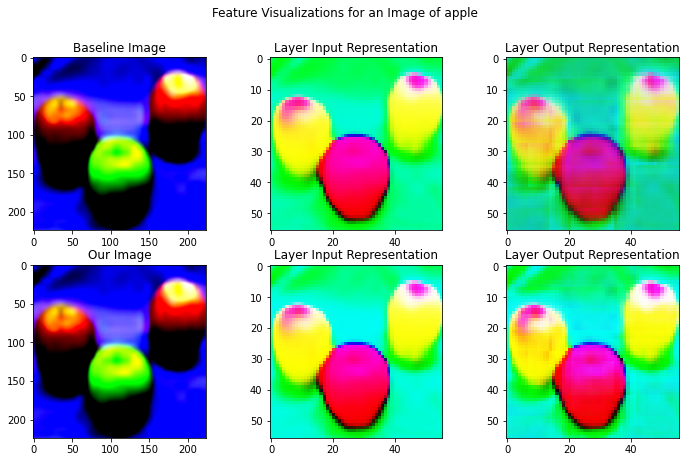

In [64]:
plot_layer_features_side_by_side(bl_features, our_features, label_names, cpu_images, index=9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


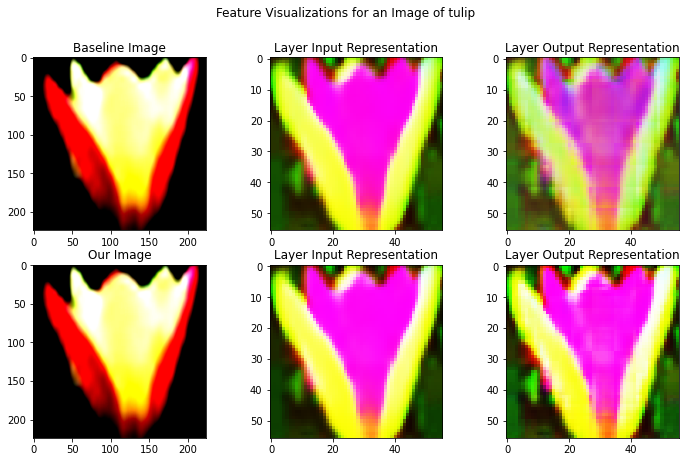

In [66]:
plot_layer_features_side_by_side(bl_features, our_features, label_names, cpu_images, index=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


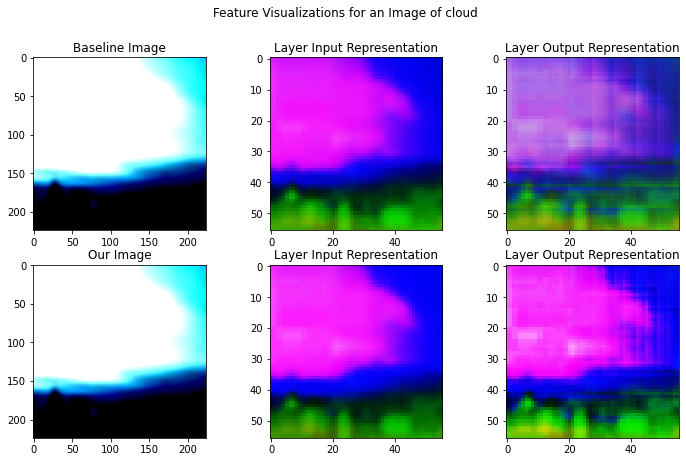

In [71]:
plot_layer_features_side_by_side(bl_features, our_features, label_names, cpu_images, index=8)

#### It looks like we can achieve higher detailing than the baseline model in our output resolution map. So why do we only see such small performance difference?

## Investigating Whitespace in PCA components

In [114]:
print(csam_features['output_reduced'].min(), csam_features['output_reduced'].max())
print(csam_features['output_features'].min(), csam_features['output_features'].max())

-111.17941 151.28227
-68.86684 74.96446


In [115]:
print(csam_features['input_reduced'].min(), csam_features['input_reduced'].max())
print(csam_features['input_features'].min(), csam_features['input_features'].max())

-44.43169 15.632654
-8.961408 10.208941


In [143]:
(csam_features['output_features'] / csam_features['input_features'])[27].min()

-86042.74

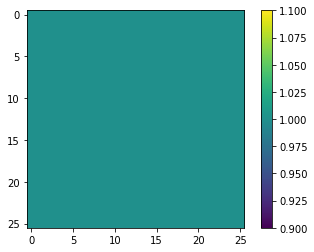

In [213]:
plt.colorbar(plt.imshow(sigmoid(csam_features['filter_values'][1].reshape(30, 30)[2:-2, 2:-2])))

In [215]:
csam_features['filter_values'].reshape(128, 30, 30)[:, 1:-1, 1:-1][0]

array([[224.20518, 217.37631, 230.44965, 233.88303, 232.1144 , 228.65454,
        232.52747, 237.01266, 239.358  , 247.63976, 224.72763, 235.10524,
        231.5344 , 219.3446 , 216.94122, 233.88994, 225.68594, 233.48874,
        260.48297, 245.09888, 234.70169, 219.0062 , 225.42625, 221.38525,
        201.5802 , 225.08995, 226.05446, 183.20041],
       [276.013  , 247.58173, 241.12524, 256.17896, 251.05798, 243.81073,
        241.26927, 254.24432, 265.61566, 249.58511, 248.05566, 242.82935,
        235.82188, 228.2984 , 220.81305, 229.10487, 218.68018, 204.52263,
        246.14621, 218.34111, 229.8949 , 223.27173, 221.45654, 237.94308,
        212.03326, 195.19817, 190.10736, 202.6312 ],
       [264.1588 , 237.77617, 249.95164, 233.50261, 227.85507, 210.83112,
        204.69002, 196.80028, 191.18784, 190.74567, 197.87273, 201.43408,
        196.06914, 194.27206, 212.2421 , 200.13762, 207.46503, 195.73758,
        199.84094, 207.80682, 201.39691, 201.4321 , 201.8072 , 193.96127,
      

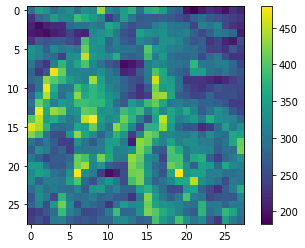

In [216]:
plt.colorbar(plt.imshow(csam_features['filter_values'][27].reshape(30, 30)[1:-1, 1:-1]))

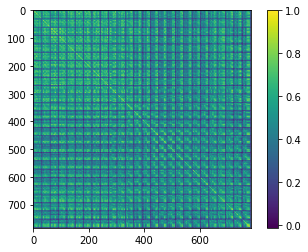

In [219]:
plt.colorbar(plt.imshow(csam_features['scores'][1].reshape(900, 900)[58:-58, 58:-58]))

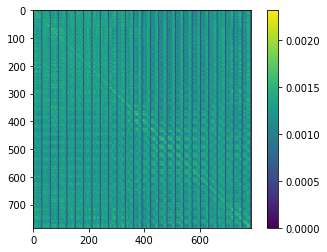

In [221]:
plt.colorbar(plt.imshow(csam_features['attention_matrix'][1].reshape(900, 900)[58:-58, 58:-58]))

In [240]:
(csam_features['summary_vectors'][0, 0] * csam_features['input_features'][0, 783]).sum()

407.2057

In [165]:
summary_vectors = csam_features['summary_vectors'].reshape(128, 30, 30, 192)

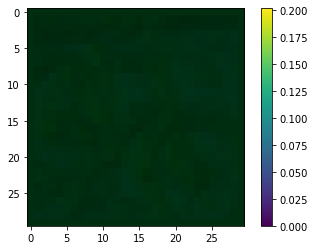

In [173]:
plt.colorbar(
    plt.imshow(
        sigmoid(
            features_PCA.transform(csam_features['summary_vectors'].reshape(-1, 192)).reshape(128, 30, 30, 3)[27]
        )
    )
)

In [179]:
from sklearn.metrics.pairwise import cosine_similarity

In [180]:
x = cosine_similarity(csam_features['summary_vectors'][27], csam_features['summary_vectors'][27])

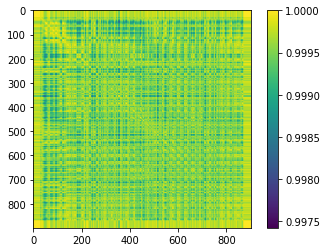

In [185]:
plt.colorbar(plt.imshow(x))

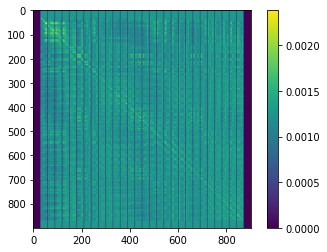

In [187]:
plt.colorbar(plt.imshow(csam_features['attention_matrix'][27]))

In [197]:
csam_features['attention_matrix'][27, 17] - csam_features['attention_matrix'][27, 7]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

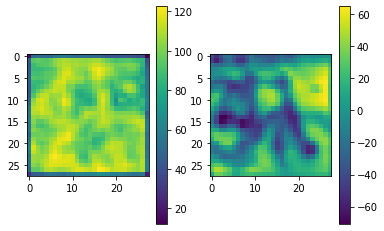

In [104]:
fig, ax = plt.subplots(1, 2)
plot_1 = ax[0].imshow(csam_features['output_reduced'][27].max(-1))
plot_2 = ax[1].imshow(csam_features['output_reduced'][27].min(-1))
plt.colorbar(plot_1, ax=ax[0])
plt.colorbar(plot_2, ax=ax[1])
plt.show()

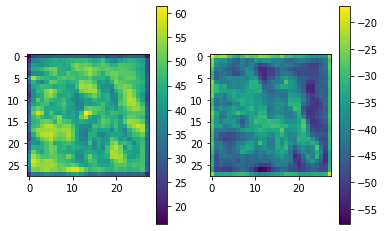

In [106]:
fig, ax = plt.subplots(1, 2)
plot_1 = ax[0].imshow(csam_features['output_features'][27].reshape(28, 28, 192).max(-1))
plot_2 = ax[1].imshow(csam_features['output_features'][27].reshape(28, 28, 192).min(-1))
plt.colorbar(plot_1, ax=ax[0])
plt.colorbar(plot_2, ax=ax[1])
plt.show()

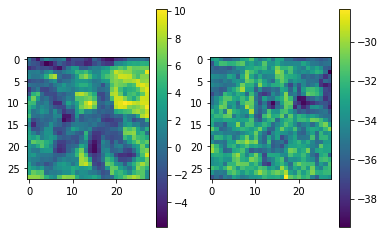

In [107]:
fig, ax = plt.subplots(1, 2)
plot_1 = ax[0].imshow(csam_features['input_reduced'][27].max(-1))
plot_2 = ax[1].imshow(csam_features['input_reduced'][27].min(-1))
plt.colorbar(plot_1, ax=ax[0])
plt.colorbar(plot_2, ax=ax[1])
plt.show()

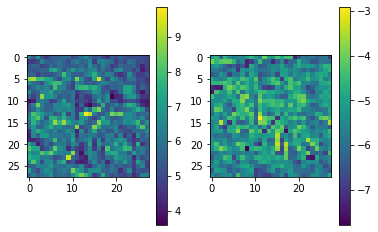

In [108]:
fig, ax = plt.subplots(1, 2)
plot_1 = ax[0].imshow(csam_features['input_features'][27].reshape(28, 28, 192).max(-1))
plot_2 = ax[1].imshow(csam_features['input_features'][27].reshape(28, 28, 192).min(-1))
plt.colorbar(plot_1, ax=ax[0])
plt.colorbar(plot_2, ax=ax[1])
plt.show()

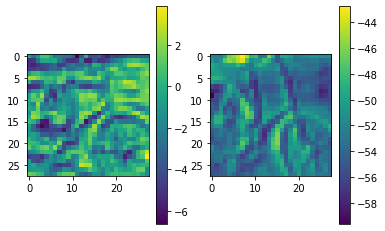

In [109]:
fig, ax = plt.subplots(1, 2)
plot_1 = ax[0].imshow(csam_features['bl_input_reduced'][27].max(-1))
plot_2 = ax[1].imshow(csam_features['bl_input_reduced'][27].min(-1))
plt.colorbar(plot_1, ax=ax[0])
plt.colorbar(plot_2, ax=ax[1])
plt.show()

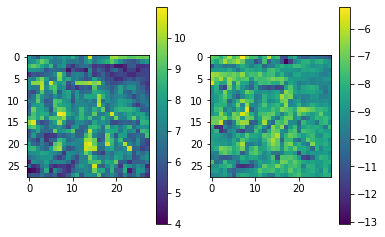

In [113]:
fig, ax = plt.subplots(1, 2)
plot_1 = ax[0].imshow(bl_features['input_features'][27].reshape(28, 28, 192).max(-1))
plot_2 = ax[1].imshow(bl_features['input_features'][27].reshape(28, 28, 192).min(-1))
plt.colorbar(plot_1, ax=ax[0])
plt.colorbar(plot_2, ax=ax[1])
plt.show()

# Track Missclassifications

#### Helper functions

In [37]:
@torch.no_grad()
def get_class_characteristics(data_loader, model, id2label):
    class2correctness2image_ids = defaultdict(lambda: defaultdict(lambda: list()))
    all_images = []
    model.eval()

    end = time.time()
    count = 0
    for idx, (images, target) in tqdm(enumerate(data_loader)):
        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(images, use_amp=False)
        predictions = output.argsort(dim=-1, descending=True)[:, 0].reshape(-1)
        correctness = predictions == target.reshape(-1)
        
        for batch_idx, (is_correct, label, image) in enumerate(zip(correctness, target, images)):
            count += 1
            label = label.detach().cpu().numpy().tolist()
            is_correct = is_correct.detach().cpu().numpy().tolist()
            class2correctness2image_ids[id2label[label]][is_correct].append(count
            )
            all_images.append(image.detach().cpu().numpy())
            
    return class2correctness2image_ids, all_images

def dataframify_correctness_dict(dictionary):
    flat_dict = {
    'class': [],
    'correct_frequency': [],
    'wrong_frequency': []
    }

    for class_name, correctness2image_ids in dictionary.items():
        flat_dict['class'].append(class_name)
        for is_correct, image_ids in correctness2image_ids.items():
            if is_correct:
                flat_dict['correct_frequency'].append(len(image_ids))
            else:
                flat_dict['wrong_frequency'].append(len(image_ids))
    return pd.DataFrame(data=flat_dict)

#### Get class correctness characteristics.
This is basically a dictionary that is: 
{class_name: {correct: [list of correctly classified image_ids], wrong: [list of wrongly classified image_ids]}, ...}

In [38]:
csam_class2correctness2image_ids, all_images = get_class_characteristics(csam_data_loader_val, csam_model, id2label)
bl_class2correctness2image_ids, _ = get_class_characteristics(bl_data_loader_val, bl_model, id2label)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
79it [00:19,  4.13it/s]
79it [00:18,  4.33it/s]


In [39]:
len(all_images), len(_)

(10000, 10000)

In [40]:
len(bl_class2correctness2image_ids)

100

#### Turn dicts into dataframes for plotting

In [41]:
bl_df = dataframify_correctness_dict(bl_class2correctness2image_ids)
bl_df = bl_df.set_index('class')
bl_df_ = bl_df.cumsum(axis=1)

In [42]:
csam_df = dataframify_correctness_dict(csam_class2correctness2image_ids)
csam_df = csam_df.set_index('class')
csam_df_ = csam_df.cumsum(axis=1)

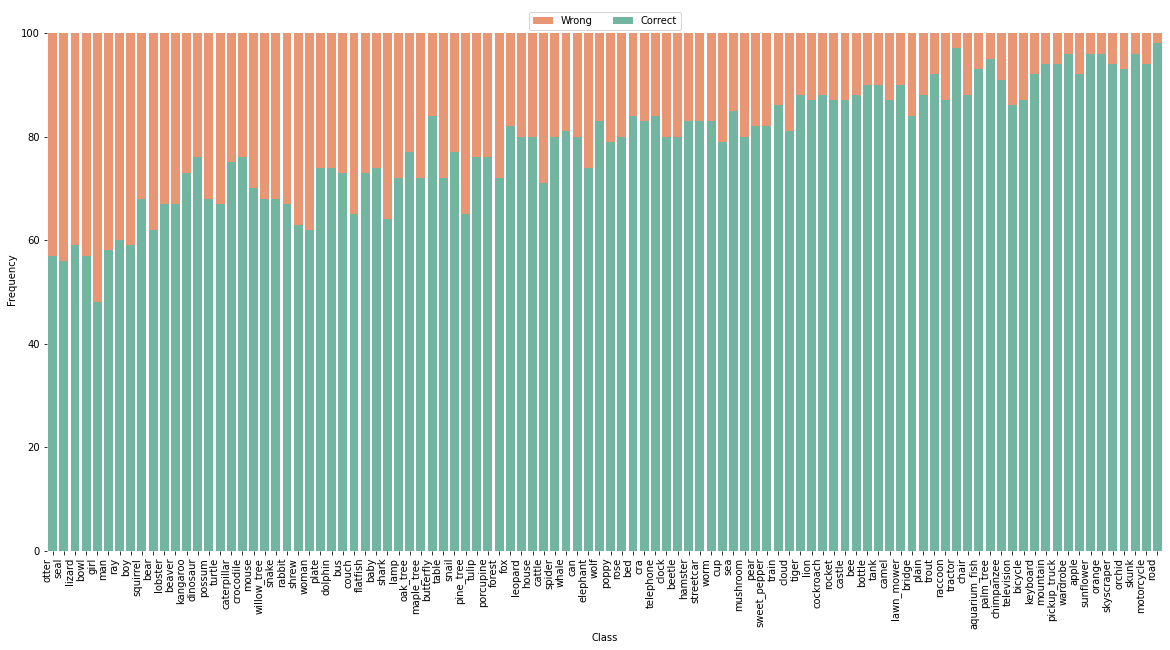

In [43]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = bl_df_.index, 
    y = bl_df_['wrong_frequency'], 
    label='Wrong',   
    color=sns.color_palette("Set2", 10)[1],
    order = bl_df.sort_values('correct_frequency').index
)

sns.barplot(
    x = csam_df_.index, y = csam_df_['correct_frequency'], 
    label='Correct',  
    color=sns.color_palette("Set2", 10)[0],
    order = bl_df.sort_values('correct_frequency').index
)

plt.ylabel("Frequency")
plt.xlabel("Class")
ax.legend(ncol=7, loc="upper center", frameon=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

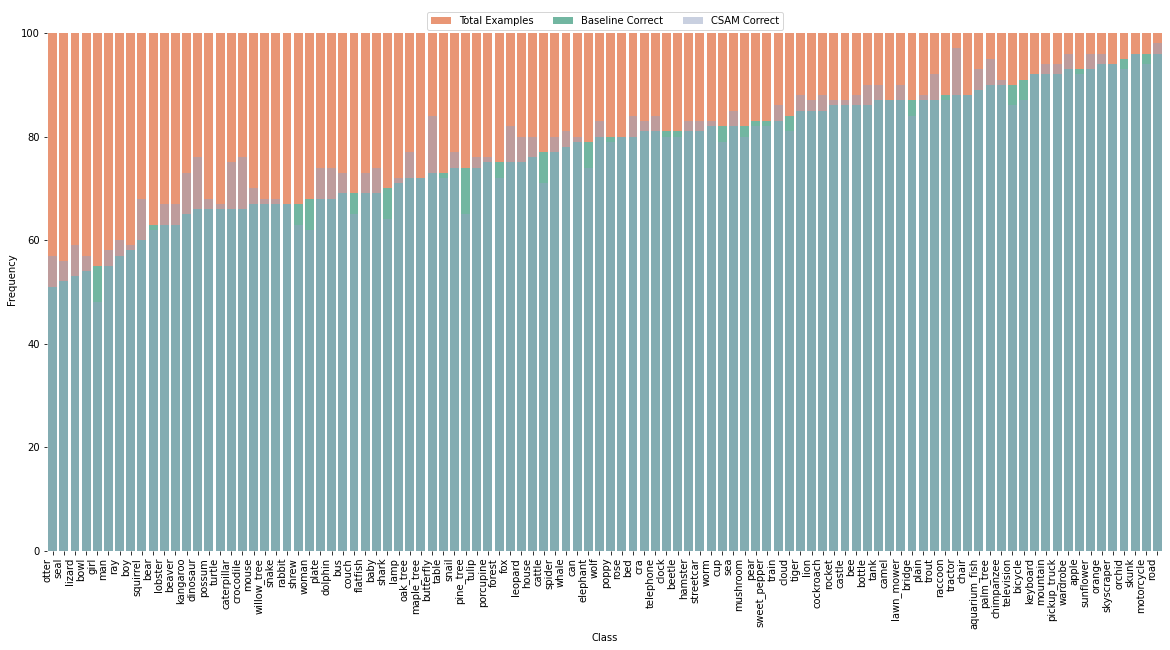

In [44]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = bl_df_.index, 
    y = bl_df_['wrong_frequency'], 
    label='Total Examples',   
    color=sns.color_palette("Set2", 10)[1],
    order = bl_df_.sort_values('correct_frequency').index
)

sns.barplot(
    x = bl_df_.index, y = bl_df_['correct_frequency'], 
    label='Baseline Correct',  
    color=sns.color_palette("Set2", 10)[0],
    order = bl_df_.sort_values('correct_frequency').index
)

sns.barplot(
    x = csam_df_.index, y = csam_df_['correct_frequency'], 
    label='CSAM Correct',  
    color=sns.color_palette("Set2", 10)[2],
    order = bl_df_.sort_values('correct_frequency').index,
    alpha=.5
)

plt.ylabel("Frequency")
plt.xlabel("Class")
ax.legend(ncol=7, loc="upper center", frameon=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [45]:
diff_df = bl_df.subtract(csam_df, axis="columns")
diff_df

,correct_frequency,wrong_frequency
class,,
mountain,-2,2
forest,3,-3
seal,-4,4
mushroom,2,-2
sea,-3,3
...,...,...
telephone,-3,3
bed,-4,4
motorcycle,2,-2


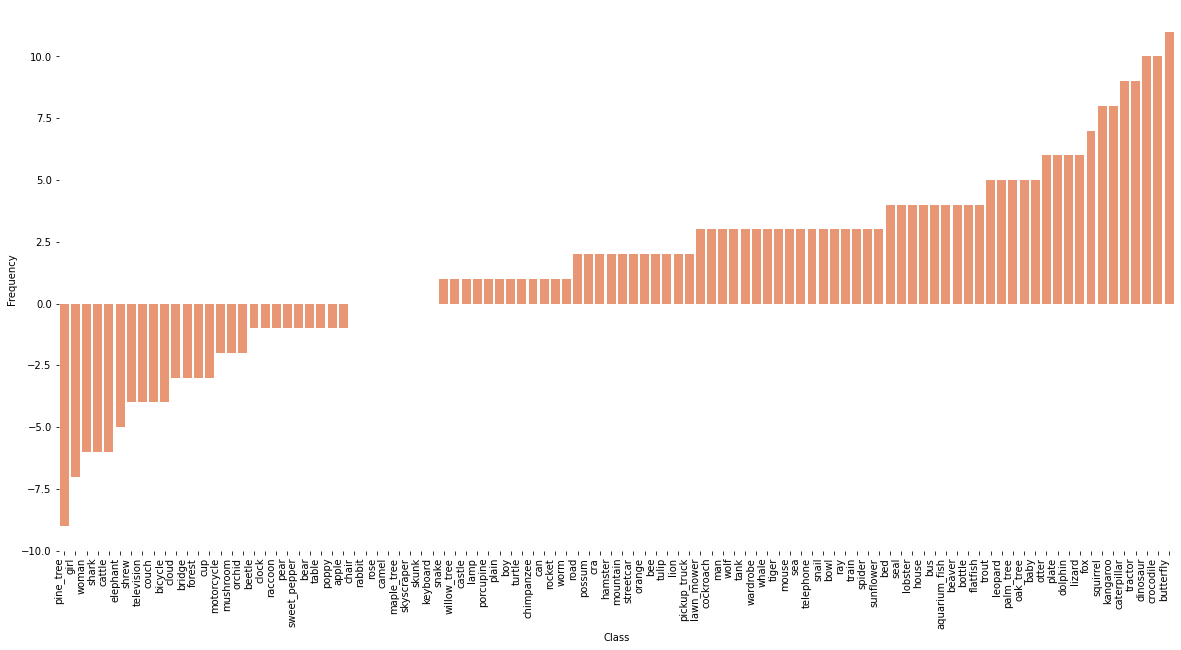

In [46]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = diff_df.index, 
    y = diff_df['wrong_frequency'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)

plt.ylabel("Frequency")
plt.xlabel("Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

# Entropy Visualizations

#### Helper functions

In [47]:
@torch.no_grad()
def get_class_entropies(data_loader, model, id2label):
    class2correctness2entropies = defaultdict(lambda: defaultdict(lambda: list()))
    model.eval()

    end = time.time()
    count = 0
    for idx, (images, target) in tqdm(enumerate(data_loader)):
        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        outputs = model(images, use_amp=False)
        predictions = outputs.argsort(dim=-1, descending=True)[:, 0].reshape(-1)
        correctness = predictions == target.reshape(-1)
        
        for batch_idx, (is_correct, label, image, output) in enumerate(zip(correctness, target, images, outputs)):
            count += 1
            label = label.detach().cpu().numpy().tolist()
            is_correct = is_correct.detach().cpu().numpy().tolist()
            output_entropy = torch.distributions.Categorical(
                F.softmax(output)
            ).entropy().detach().cpu().numpy().tolist()
            class2correctness2entropies[id2label[label]][is_correct].append(output_entropy)
            
    return class2correctness2entropies

def dataframify_entropy_dict(dictionary):
    flat_dict = {
    'class': [],
    'correct_entropy': [],
    'wrong_entropy': [],
    'overall': []
    }

    for class_name, correctness2entropies in dictionary.items():
        flat_dict['class'].append(class_name)
        for is_correct, entropies in correctness2entropies.items():
            if is_correct:
                flat_dict['correct_entropy'].append(np.mean(entropies))
            else:
                flat_dict['wrong_entropy'].append(np.mean(entropies))
        flat_dict['overall'].append(
            np.concatenate(list(correctness2entropies.values())).mean()
        )
    return pd.DataFrame(data=flat_dict)

#### Get class entropy distributions

In [48]:
bl_class2correctness2entropies = get_class_entropies(bl_data_loader_val, bl_model, id2label)
csam_class2correctness2entropies = get_class_entropies(csam_data_loader_val, csam_model, id2label)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
79it [00:19,  4.10it/s]
0it [00:00, ?it/s]/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use to

#### Turn dicts into dataframes for plotting

In [49]:
bl_entropy_df = dataframify_entropy_dict(bl_class2correctness2entropies)
bl_entropy_df = bl_entropy_df.set_index('class')

csam_entropy_df = dataframify_entropy_dict(csam_class2correctness2entropies)
csam_entropy_df = csam_entropy_df.set_index('class')

In [50]:
ratio_df = bl_entropy_df.divide(csam_entropy_df, axis="columns")
ratio_df

,correct_entropy,wrong_entropy,overall
class,,,
mountain,1.135509,1.054733,1.146328
forest,1.072163,1.082876,1.060240
seal,1.109789,0.982205,1.053849
mushroom,0.919402,0.997021,0.924176
sea,1.027517,1.067399,1.062498
...,...,...,...
telephone,0.870786,1.127512,0.984491
bed,1.139049,1.026154,1.138349
motorcycle,0.973784,1.082607,0.958526


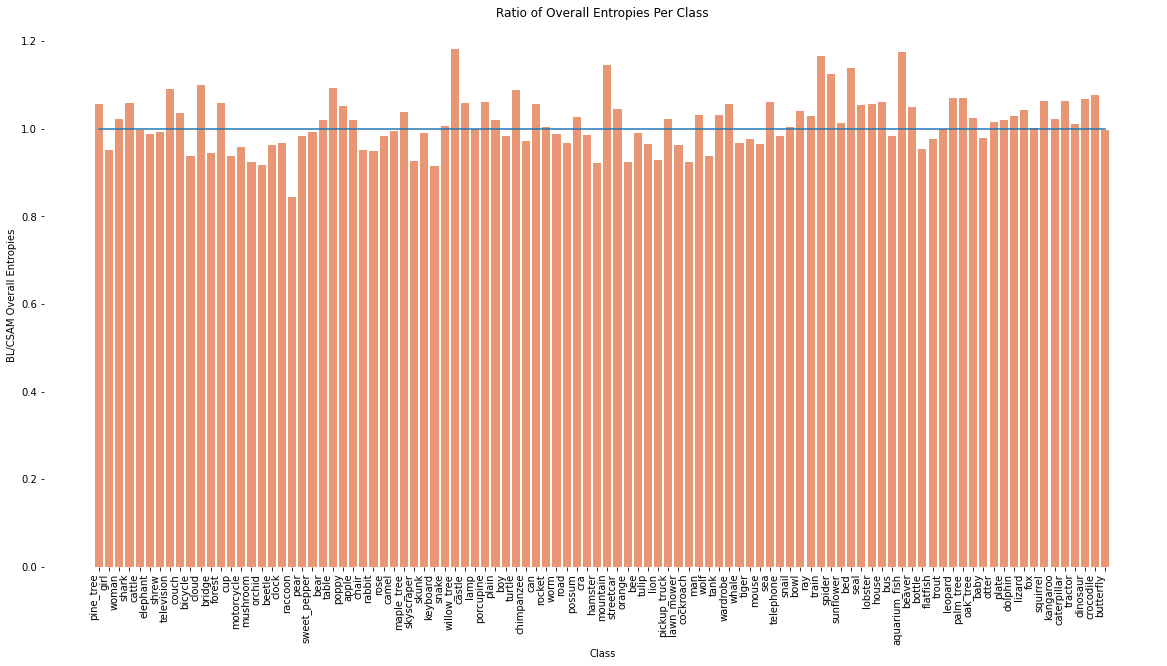

In [51]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = ratio_df.index, 
    y = ratio_df['overall'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)
plt.plot([1.] * 100)
plt.ylabel("BL/CSAM Overall Entropies")
plt.xlabel("Class")
plt.title("Ratio of Overall Entropies Per Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [52]:
(ratio_df['overall'] > 1.).sum()

54

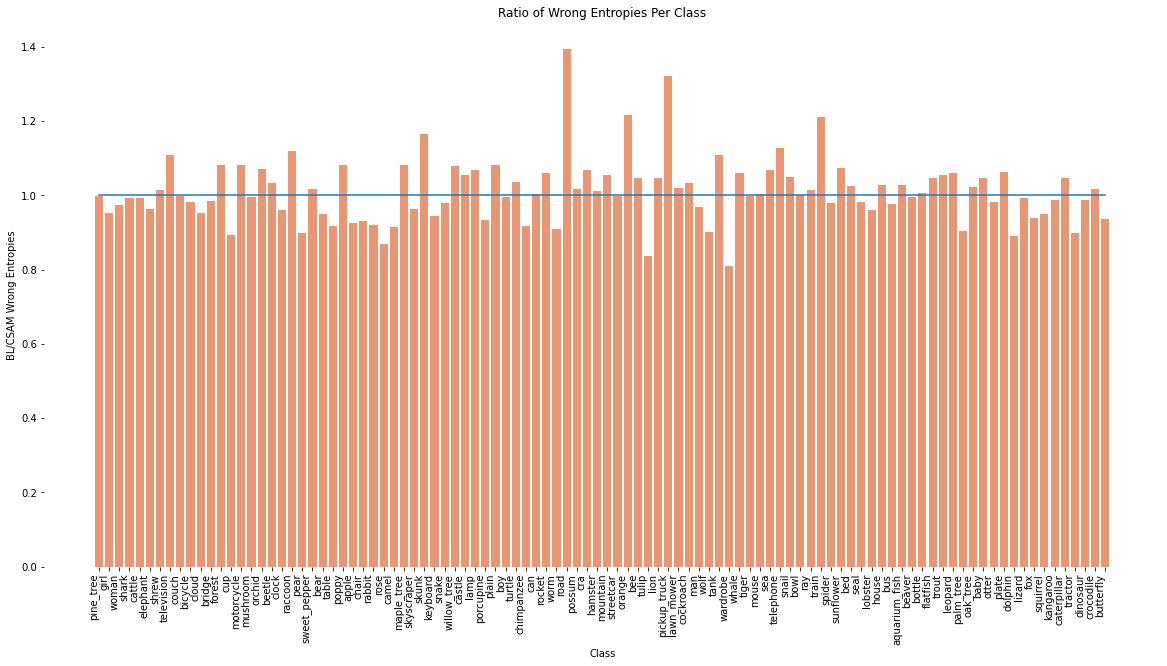

In [53]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = ratio_df.index, 
    y = ratio_df['wrong_entropy'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)
plt.plot([1.] * 100)
plt.ylabel("BL/CSAM Wrong Entropies")
plt.xlabel("Class")
plt.title("Ratio of Wrong Entropies Per Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [54]:
(ratio_df['wrong_entropy'] > 1.).sum()

51

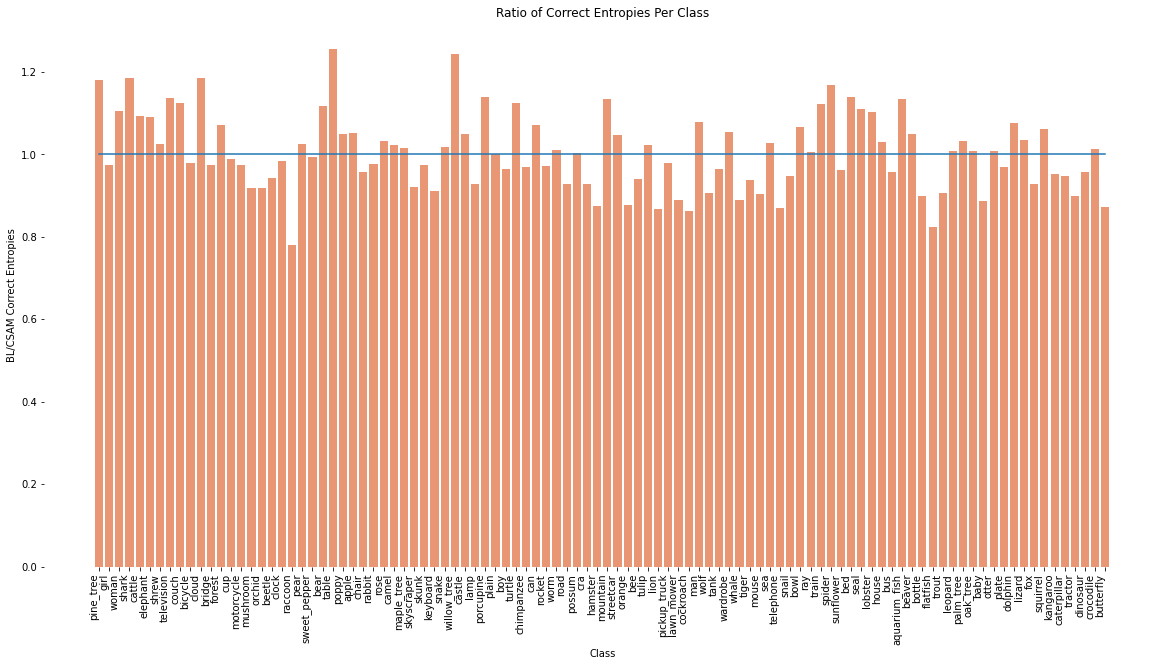

In [55]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    x = ratio_df.index, 
    y = ratio_df['correct_entropy'], 
    color=sns.color_palette("Set2", 10)[1],
    order = diff_df.sort_values('wrong_frequency').index
)
plt.plot([1.] * 100)
plt.ylabel("BL/CSAM Correct Entropies")
plt.xlabel("Class")
plt.title("Ratio of Correct Entropies Per Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
sns.despine(left=True, bottom=True)

In [56]:
(ratio_df['correct_entropy'] > 1.).sum()

51